<div style="direction:rtl;line-height:300%;">
	<font face="B Nazanin" size=5>
		<div align=center>
			<font face="IranNastaliq" size=30>
				<p></p>
				<p></p>
به نام خدا
				<p></p>
							<br />
			</font>
			<font color=#FF7500>
دانشگاه صنعتی اصفهان - دانشکده مهندسی برق و کامپیوتر
            </font>
			<p></p>
			<font color=blue>
			<br />
مبانی هوش محاسباتی
			<br />
            </font>
			<br />
بهار ۱۴۰۲
		</div>
		<hr/>
		<font color=red size=6>
			<br />
			<div align=center>	
تکلیف کامپیوتری دوم
            </div>
		</font>
		<font color=green size=6>
			<br />
			<div align=center>	
علیرضا ابره فروش
            </div>
		</font>
		<font color=green size=6>
			<br />
			<div align=center>	
9816603
            </div>
		</font>
		<br />
		<hr />
		<style type="text/css" scoped>
        p{
        border: 1px solid #a2a9b1;background-color: #f8f9fa;display: inline-block;
        };
        </style>
	</font>
</div>

In [1]:
import wandb as wb
import tensorflow as tf
import torch as tc
import torchvision as tcv
import matplotlib.pyplot as plt
import numpy as np

from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
from torchvision.utils import make_grid

In [2]:
#choosing device running model
dev2 = tc.device('cuda' if tc.cuda.is_available() else 'cpu')
print('Device:', dev2)
print('GPU Model:', tc.cuda.get_device_name(dev2))

Device: cuda
GPU Model: GeForce GTX 1650


In [3]:
#train, validation, and test data directory
train_data_dir = "HW02-Practical/Dataset/train"
valid_data_dir = "HW02-Practical/Dataset/valid"
test_data_dir = "HW02-Practical/Dataset/test"

In [4]:
#generating suitable transform for the images (resize)
input_img_dim = 150
rsz = transforms.Compose([
    transforms.Resize((input_img_dim, input_img_dim)), transforms.ToTensor()
])

In [5]:
#load the train, validation, and test data with applying specific transforms
train_dataset = ImageFolder(train_data_dir, transform = rsz)
valid_dataset = ImageFolder(valid_data_dir, transform = rsz)
test_dataset = ImageFolder(test_data_dir, transform = rsz)

In [6]:
#check whether the dataset is loaded
img, label = train_dataset[0]
print(img.shape, label)

torch.Size([3, 150, 150]) 0


In [7]:
#see the available classes in the dataset
print("Follwing classes are there : \n", train_dataset.classes)

Follwing classes are there : 
 ['articulated_truck', 'background', 'bus', 'car', 'work_van']


Label : articulated_truck


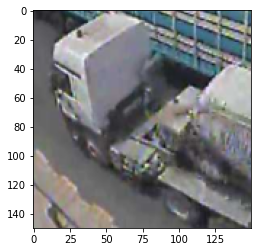

In [8]:
#display and image including its label
def display_img(img, label):
    print(f"Label : {train_dataset.classes[label]}")
    plt.imshow(img.permute(1, 2, 0))

#display the first image in the dataset
display_img(*train_dataset[0])

In [9]:
underfit_batch_size = 128

#load the train and validation into batches.
underfit_train_dl = DataLoader(train_dataset, underfit_batch_size, shuffle = True, num_workers = 4, pin_memory = True)
underfit_valid_dl = DataLoader(valid_dataset, underfit_batch_size * 2, num_workers = 4, pin_memory = True)
underfit_test_dl = DataLoader(test_dataset, underfit_batch_size * 2, num_workers = 4, pin_memory = True)

In [10]:
#to empty the gpu memory
tc.cuda.empty_cache()

In [11]:
#moving image datasets to gpu
for batch in underfit_train_dl:
    batch = [tensor.to(dev2) for tensor in batch]
for batch in underfit_valid_dl:
    batch = [tensor.to(dev2) for tensor in batch]
for batch in underfit_test_dl:
    batch = [tensor.to(dev2) for tensor in batch]

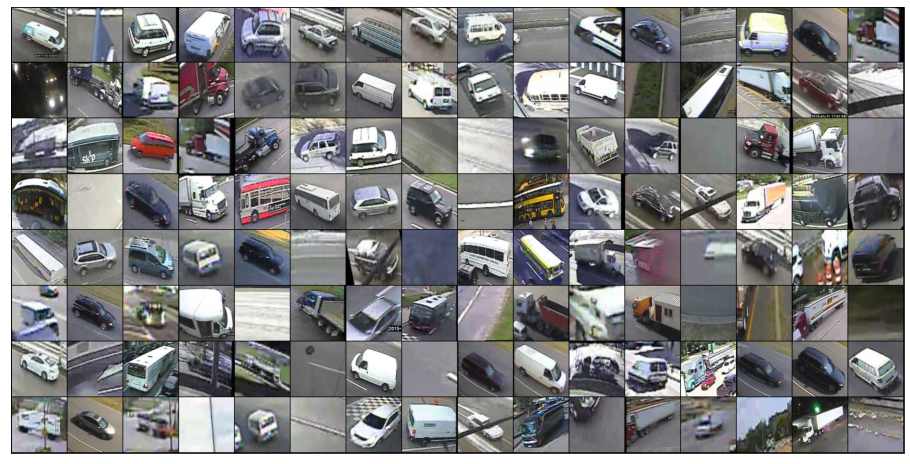

In [12]:
def show_batch(dl):
    """Plot images grid of single batch"""
    for images, labels in dl:
        fig, ax = plt.subplots(figsize = (16, 12))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images, nrow = 16).permute(1, 2, 0))
        break
        
show_batch(underfit_train_dl)

In [13]:
def accuracy(outputs, labels):
    _, preds = tc.max(outputs, dim=1)
    return tc.tensor(tc.sum(preds == labels).item() / len(preds))

In [14]:
import torch.nn as nn
import torch.nn.functional as F

class ImageClassificationBase(nn.Module):
    
    def trainingStep(self, batch):
        #images, labels = batch
        images, labels = [tensor.to(dev2) for tensor in batch]
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validationStep(self, batch):
        #images, labels = batch
        images, labels = [tensor.to(dev2) for tensor in batch]
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validationEpochEnd(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = tc.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = tc.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epochEnd(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [15]:
@tc.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validationStep(batch) for batch in val_loader]
    return model.validationEpochEnd(outputs)

  
def fit(epochs, lr, model, train_loader, val_loader, opt_func = tc.optim.SGD):
    
    history = []
    optimizer = opt_func(model.parameters(),lr)
    for epoch in range(epochs):
        
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.trainingStep(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        result = evaluate(model, val_loader)
        result['train_loss'] = tc.stack(train_losses).mean().item()
        model.epochEnd(epoch, result)
        history.append(result)
    
    return history

## 1

#### آ

In [16]:
class UnderfitVehicleClassification(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Flatten(),
            nn.Linear(32 * 75 * 75, 6)
        )
    
    def forward(self, xb):
        return self.network(xb)

In [17]:
underfit_model = UnderfitVehicleClassification()
underfit_model.to(dev2)

UnderfitVehicleClassification(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Flatten(start_dim=1, end_dim=-1)
    (4): Linear(in_features=180000, out_features=6, bias=True)
  )
)

In [18]:
#fitting the model on training data and record the result after each epoch
num_epochs = 15
opt_func = tc.optim.Adam
lr = 0.001
underfit_history = fit(num_epochs, lr, underfit_model, underfit_train_dl, underfit_valid_dl, opt_func)

Epoch [0], train_loss: 4.1765, val_loss: 0.8389, val_acc: 0.6950
Epoch [1], train_loss: 0.6216, val_loss: 0.7591, val_acc: 0.7348
Epoch [2], train_loss: 0.4651, val_loss: 0.6989, val_acc: 0.7571
Epoch [3], train_loss: 0.3793, val_loss: 0.6417, val_acc: 0.7743
Epoch [4], train_loss: 0.3097, val_loss: 0.6863, val_acc: 0.7746
Epoch [5], train_loss: 0.2556, val_loss: 0.7143, val_acc: 0.7728
Epoch [6], train_loss: 0.2115, val_loss: 0.7042, val_acc: 0.7803
Epoch [7], train_loss: 0.1770, val_loss: 0.6880, val_acc: 0.7872
Epoch [8], train_loss: 0.1517, val_loss: 0.6998, val_acc: 0.7866
Epoch [9], train_loss: 0.1210, val_loss: 0.7160, val_acc: 0.7927
Epoch [10], train_loss: 0.1085, val_loss: 0.7281, val_acc: 0.7920
Epoch [11], train_loss: 0.0893, val_loss: 0.7699, val_acc: 0.7919
Epoch [12], train_loss: 0.0702, val_loss: 0.8204, val_acc: 0.7805
Epoch [13], train_loss: 0.0615, val_loss: 0.8355, val_acc: 0.7788
Epoch [14], train_loss: 0.0526, val_loss: 0.8174, val_acc: 0.7860


In [19]:
def plot_accuracies(history):
    """ Plot the history of accuracies"""
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')

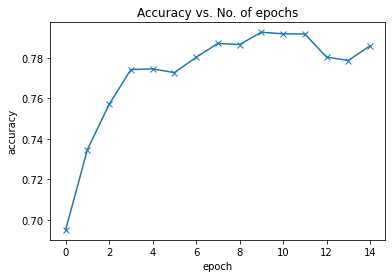

In [20]:
plot_accuracies(underfit_history)

In [21]:
def plot_losses(history):
    """ Plot the losses in each epoch"""
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')

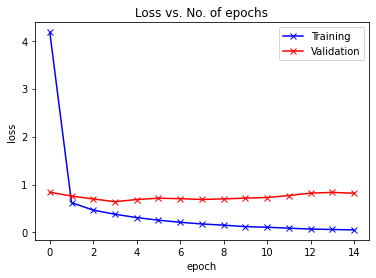

In [22]:
plot_losses(underfit_history)

In [23]:
evaluate(underfit_model, underfit_test_dl)

{'val_loss': 1.0113400220870972, 'val_acc': 0.7611442804336548}

<div style="direction:rtl;line-height:300%;">
	<font face="B Nazanin" size=5>
		<div align=center>
یک مدل شبکه عصبی کانولوشنال (CNN) معمولاً به عنوان underfit شناخته می‌شود زمانی که ناتوان در یادگیری پیچیدگی داده‌های ورودی است و نمی‌تواند الگوها یا نمایندگی‌های معناداری از ورودی یاد بگیرد.

دلایل زیر را می‌توان برای underfit بودن یک مدل CNN برشمرد:

ظرفیت مدل: ممکن است ظرفیت یا پیچیدگی مدل برای یادگیری الگوهای داده ناکافی باشد. مدل‌های CNN شامل لایه‌های کانولوشنال برای استخراج ویژگی‌ها و لایه‌های کاملاً متصل برای انجام دسته‌بندی هستند. اگر مدل کافی عمیق یا گسترده نباشد، ممکن است در یادگیری روابط پیچیده مشکل داشته باشد و خوب به داده‌های ناشناخته واکنش ندهد.

اندازه داده‌های آموزش: اگر مجموعه داده آموزش کوچک باشد، ممکن است مدل تعداد کافی نمونه‌های متنوع برای یادگیری نداشته باشد. در چنین مواردی، ممکن است مدل نتواند به خوبی به داده‌های ناشناخته واکنش نشان دهد و منجر به underfit شود.

زمان آموزش: کمبود زمان آموزش یا تعداد کمی از حلقات آموزش می‌تواند منجر به underfit شود. مدل نیاز به تعداد کافی از تکرارها برای تنظیم پارامترهای خود و یادگیری بهینه از داده دارد.

منظم‌سازی: روش‌های منظم‌سازی مانند dropout یا weight decay معمولاً برای جلوگیری از overfit استفاده می‌شوند، اما اگر به طور زیادی استفاده شوند، ممکن است آموزش مدل را محدود کنند و به underfit منجر شوند.

کیفیت داده: اگر کیفیت داده‌ها ضعیف باشد و شامل نویز یا ناهنجاری باشد، ممکن است مدل در یادگیری الگوهای معنادار مشکل داشته باشد. قبل از آموزش مدل، مهم است که داده‌ها را به درستی پیش‌پردازش و پاک‌سازی کنید.
    		</div>
		<hr/>
	</font>
</div>

#### ب

In [24]:
#to empty the gpu memory
tc.cuda.empty_cache()

In [19]:
overfit_batch_size = 16

#load the train and validation into batches.
overfit_train_dl = DataLoader(train_dataset, overfit_batch_size, shuffle = True, num_workers = 4, pin_memory = True)
overfit_valid_dl = DataLoader(valid_dataset, overfit_batch_size * 2, num_workers = 4, pin_memory = True)
overfit_test_dl = DataLoader(test_dataset, overfit_batch_size * 2, num_workers = 4, pin_memory = True)

In [26]:
#moving image datasets to gpu
for batch in overfit_train_dl:
    batch = [tensor.to(dev2) for tensor in batch]
for batch in overfit_valid_dl:
    batch = [tensor.to(dev2) for tensor in batch]
for batch in overfit_test_dl:
    batch = [tensor.to(dev2) for tensor in batch]

In [17]:
class OverfitVehicleClassification(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Flatten(),
            nn.Linear(256 * 18 * 18, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 6)
        )
    
    def forward(self, xb):
        return self.network(xb)

In [31]:
overfit_model = OverfitVehicleClassification()
overfit_model.to(dev2)

OverfitVehicleClassification(
  (network): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Flatten(start_dim=1, end_dim=-1)
    (10): Linear(in_features=82944, out_features=512, bias=True)
    (11): ReLU()
    (12): Dropout(p=0.5, inplace=False)
    (13): Linear(in_features=512, out_features=256, bias=True)
    (14): ReLU()
    (15): Dropout(p=0.5, inplace=False)
    (16): Linear(in_features=256, out_features=6, bias=True)
  )
)

In [32]:
#fitting the model on training data and record the result after each epoch
num_epochs = 15
opt_func = tc.optim.Adam
lr = 0.001
overfit_history = fit(num_epochs, lr, overfit_model, overfit_train_dl, overfit_valid_dl, opt_func)

Epoch [0], train_loss: 0.8858, val_loss: 0.6420, val_acc: 0.7832
Epoch [1], train_loss: 0.4960, val_loss: 0.5604, val_acc: 0.8065
Epoch [2], train_loss: 0.3322, val_loss: 0.5023, val_acc: 0.8589
Epoch [3], train_loss: 0.2438, val_loss: 0.4392, val_acc: 0.8617
Epoch [4], train_loss: 0.1827, val_loss: 0.5349, val_acc: 0.8575
Epoch [5], train_loss: 0.1495, val_loss: 0.5820, val_acc: 0.8575
Epoch [6], train_loss: 0.1201, val_loss: 0.4937, val_acc: 0.8696
Epoch [7], train_loss: 0.1131, val_loss: 0.5012, val_acc: 0.8800
Epoch [8], train_loss: 0.0839, val_loss: 0.5517, val_acc: 0.8726
Epoch [9], train_loss: 0.0945, val_loss: 0.5642, val_acc: 0.8648
Epoch [10], train_loss: 0.0759, val_loss: 0.6804, val_acc: 0.8684
Epoch [11], train_loss: 0.0746, val_loss: 0.6390, val_acc: 0.8668
Epoch [12], train_loss: 0.0736, val_loss: 0.6136, val_acc: 0.8778
Epoch [13], train_loss: 0.0593, val_loss: 0.5409, val_acc: 0.8714
Epoch [14], train_loss: 0.0693, val_loss: 0.5719, val_acc: 0.8806


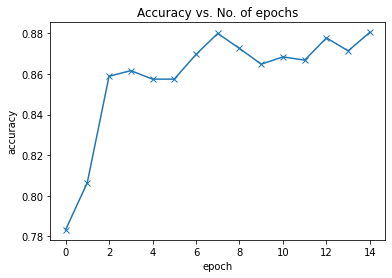

In [33]:
plot_accuracies(overfit_history)

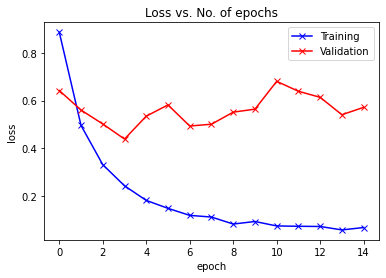

In [34]:
plot_losses(overfit_history)

In [35]:
evaluate(overfit_model, overfit_test_dl)

{'val_loss': 0.7251638174057007, 'val_acc': 0.8568869233131409}

In [36]:
overfit_history[2]

{'val_loss': 0.502275824546814,
 'val_acc': 0.8588773608207703,
 'train_loss': 0.33215072751045227}

<div style="direction:rtl;line-height:300%;">
	<font face="B Nazanin" size=5>
		<div align=center>
یک مدل شبکه عصبی کانولوشنال (CNN) به عنوان overfit شناخته می‌شود زمانی که مدل به طور غیرمناسب به داده‌های آموزش عادت کرده و قادر به عملکرد خوب در داده‌های ناشناخته نیست. این ممکن است به دلیل وجود مشکلات زیر رخ دهد:

ظرفیت بالا: ممکن است مدل overfit شود اگر ظرفیت آن بیش از حد بالا باشد. ظرفیت بالا به معنای این است که مدل بسیار پیچیده و قادر به یادگیری جزئیات بیش از حد دقیق از داده‌های آموزش است. این می‌تواند منجر به یادگیری نقص‌ها و نویزهای وجود داشته باشد که در داده‌های آموزش وجود دارند.

تعداد کم داده‌های آموزش: اگر تعداد داده‌های آموزش کم باشد، ممکن است مدل نتواند الگوهای کلی و قابلیت تعمیم به داده‌های جدید یاد بگیرد. این باعث می‌شود که مدل overfit شود و به طور نامناسب به جزئیات داده‌های آموزش عادت کند.

عدم استفاده از روش‌های منظم‌سازی: روش‌های منظم‌سازی مانند dropout، weight decay و data augmentation به عنوان روش‌هایی برای کاهش overfit استفاده می‌شوند. اگر این روش‌ها به درستی استفاده نشوند یا در تناسب مناسب با مدل و داده‌ها استفاده نشوند، ممکن است مدل overfit شود.

تعداد زیاد حلقه‌های آموزش: اگر تعداد زیادی از حلقه‌های آموزش بر روی داده‌های آموزش اعمال شود، ممکن است مدل به طور غیرمناسب به داده‌های آموزش عادت کند و عملکرد ضعیفی در داده‌های جدید نشان دهد.

داده‌های غیرمعتبر یا تقلبی: وجود داده‌های غیرمعتبر یا تقلبی می‌تواند به overfit منجر شود. این داده‌ها ممکن است شامل نویزها، اشتباهات یا اطلاعات نادرست باشند که باعث overfit مدل می‌شوند.
    	</div>
		<hr/>
	</font>
</div>

#### ج

In [44]:
tc.cuda.empty_cache()

In [20]:
num_epochs = 5
opt_func = tc.optim.Adam
overfit_history_grid = []
for i in range(1, 11):
    tc.cuda.empty_cache()
    overfit_model_grid = OverfitVehicleClassification()
    overfit_model_grid.to(dev2)
    lr = i / 10
    hist = fit(num_epochs, lr, overfit_model_grid, overfit_train_dl, overfit_valid_dl, opt_func)
    all_accuracies = []
    for x in hist:
        all_accuracies.append(x['val_acc'])
    overfit_history_grid.append(np.array(all_accuracies).mean())
    tc.cuda.empty_cache()
index_max = np.argmax(np.array(overfit_history_grid))
print("the best learning rate in the grid is: ", (index_max + 1) / 10)

Epoch [0], train_loss: 48456.9102, val_loss: 1.6236, val_acc: 0.1990
Epoch [1], train_loss: 1.6231, val_loss: 1.6285, val_acc: 0.1990
Epoch [2], train_loss: 1.6209, val_loss: 1.6358, val_acc: 0.1990
Epoch [3], train_loss: 1.6228, val_loss: 1.6098, val_acc: 0.2038
Epoch [4], train_loss: 1.6218, val_loss: 1.6172, val_acc: 0.1990
Epoch [0], train_loss: 3198074.5000, val_loss: 1.6247, val_acc: 0.1990
Epoch [1], train_loss: 55.2977, val_loss: 1.6236, val_acc: 0.1990
Epoch [2], train_loss: 5.6645, val_loss: 1.6255, val_acc: 0.1990
Epoch [3], train_loss: 4.5877, val_loss: 1.6779, val_acc: 0.2038
Epoch [4], train_loss: 2.2520, val_loss: 1.6454, val_acc: 0.1990
Epoch [0], train_loss: 29179486.0000, val_loss: 1.6815, val_acc: 0.1990
Epoch [1], train_loss: 1.6417, val_loss: 1.6267, val_acc: 0.1990
Epoch [2], train_loss: 1.6463, val_loss: 1.6247, val_acc: 0.1990
Epoch [3], train_loss: 1.6434, val_loss: 1.6147, val_acc: 0.1990
Epoch [4], train_loss: 1.6427, val_loss: 1.6310, val_acc: 0.1990
Epoch [

KeyboardInterrupt: 

###### Wandb

In [23]:
!wandb login dabc89002b4bf8da2fa0857c8aef3589b8278fea

wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\Alireza/.netrc


In [ ]:
wb.init(
    # set the wandb project where this run will be logged
    project = "Vehicle_Classification"
)

In [ ]:
hyperparameters = {
    'learning_rate': wb.grid_search([0.001, 0.01, 0.1]),
    'batch_size': wb.grid_search([16, 32, 64]),
    'num_layers': wb.grid_search([2, 3, 4])
}

In [ ]:
sweep_config = {
    'method': 'grid',
    'parameters': hyperparameters,
    'metric': {
        'name': 'val_loss',
        'goal': 'minimize'
    }
}

sweep_id = wb.sweep(sweep_config, project="your_project_name")

In [ ]:
def train():
    config_defaults = {
        'learning_rate': 0.001,
        'batch_size': 16,
        'num_layers': 2
    }

    # Initialize configuration
    wb.init(config=config_defaults)
    config = wb.config

    # Set up the model with the hyperparameters
    overfit_model = OverfitVehicleClassification()
    overfit_model.to(dev2)
    optimizer = tc.optim.Adam(overfit_model.parameters(), lr=config.learning_rate)

    # Train the model
    overfit_history = fit(num_epochs, config.learning_rate, overfit_model, overfit_train_dl, overfit_valid_dl, opt_func)

    # Log the metrics to Wandb
    wb.log({"val_loss": overfit_history[-1]["val_loss"]})

In [ ]:
wb.agent(sweep_id, train)

https://iutbox.iut.ac.ir/index.php/s/QMKEGaeaaowiF2b

## 2

In [68]:
import torchvision.models as models
from sklearn.model_selection import RandomizedSearchCV

In [69]:
class CustomModel(nn.Module):
    def __init__(self, num_classes):
        super(CustomModel, self).__init__()
        self.resnet = models.resnet18(pretrained=True)
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, num_classes)

    def forward(self, x):
        return self.resnet(x)

In [70]:
def train(model, train_loader, valid_loader, criterion, optimizer, device):
    best_val_acc = 0.0

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0

        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.size(0)

        train_loss /= len(train_loader.dataset)

        val_acc = evaluate(model, valid_loader, device)
        wb.log({"epoch": epoch, "train_loss": train_loss, "val_accuracy": val_acc})

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            tc.save(model.state_dict(), "best_model.pth")

    return best_val_acc

In [71]:
def evaluate(model, data_loader, device):
    model.eval()
    correct = 0
    total = 0

    with tc.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = tc.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    return accuracy

In [73]:
# Define the hyperparameter search space
param_grid = {
    'lr': [0.001, 0.01, 0.1],
    'batch_size': [16, 32, 64],
    'num_epochs': [10, 20, 30]
}

# Create an instance of the CustomModel
model = CustomModel(num_classes=6)
model.to(dev2)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()

# Initialize Wandb
wb.init(project="Vehicle_Classification", config=param_grid)

# Perform random search with cross-validation


C:\Users\Alireza\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Alireza\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Problem at: <ipython-input-73-0c40e05eb44f> 16 <module>


CommError: It appears that you do not have permission to access the requested resource. Please reach out to the project owner to grant you access. If you have the correct permissions, verify that there are no issues with your networking setup.(Error 403: Forbidden)

#### سناریو اول

In [48]:

# Load pre-trained ResNet18 model
resnet = models.resnet18(pretrained=True)
resnet = resnet.to(dev2)

C:\Users\Alireza\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Alireza\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [49]:
# Modify the last layer
num_classes = 6  # Number of classes in your dataset
resnet.fc = nn.Linear(resnet.fc.in_features, num_classes).to(dev2)

In [50]:
# Set all parameters to require gradients
for param in resnet.parameters():
    param.requires_grad = True

In [51]:
criterion = nn.CrossEntropyLoss()
optimizer = tc.optim.SGD(resnet.parameters(), lr=0.001, momentum=0.9)

In [52]:
criterion.to(dev2)

CrossEntropyLoss()

In [53]:
param.to(dev2)

Parameter containing:
tensor([-0.0066, -0.0289,  0.0387,  0.0284, -0.0209,  0.0330], device='cuda:0',
       requires_grad=True)

In [54]:
#moving image datasets to gpu
for batch in overfit_train_dl:
    batch = [tensor.to(dev2) for tensor in batch]
for batch in overfit_valid_dl:
    batch = [tensor.to(dev2) for tensor in batch]
for batch in overfit_test_dl:
    batch = [tensor.to(dev2) for tensor in batch]

In [55]:
for epoch in range(num_epochs):
    for images, labels in overfit_train_dl:
        # Move images and labels to the device (e.g., GPU)
        images = images.to(dev2)
        labels = labels.to(dev2)

        # Forward pass
        outputs = resnet(images)
        loss = criterion(outputs, labels)

        outputs = outputs.to(dev2)
        loss = loss.to(dev2)

        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Evaluation and logging
    # ...



In [59]:
with tc.no_grad():
    correct = 0
    total = 0
    for images, labels in overfit_valid_dl:
        images = images.to(dev2)
        labels = labels.to(dev2)
        outputs = resnet(images)
        _, predicted = tc.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Validation Accuracy: {accuracy:.2f}%")

Validation Accuracy: 31.14%


#### سناریو دوم

In [60]:
# Load the pre-trained ResNet18 model
resnet = models.resnet18(pretrained=True)

# Freeze the weights of the pre-trained model
for param in resnet.parameters():
    param.requires_grad = False

C:\Users\Alireza\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Alireza\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [61]:
# Modify the last layer of ResNet18 for your classification task
num_classes = 6  # Number of classes in your dataset
resnet.fc = nn.Linear(resnet.fc.in_features, num_classes)

In [62]:

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = tc.optim.Adam(resnet.fc.parameters(), lr=0.001)

# Move the model to the device (CPU or GPU)
resnet = resnet.to(dev2)

In [64]:
# Training loop
num_epochs = 10

for epoch in range(num_epochs):
    running_loss = 0.0
    
    for images, labels in overfit_train_dl:
        # Move images and labels to the device
        images = images.to(dev2)
        labels = labels.to(dev2)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = resnet(images)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        # Track the loss
        running_loss += loss.item()
    
    # Print the average loss for the epoch
    epoch_loss = running_loss / len(overfit_train_dl)
    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {epoch_loss:.4f}")

Epoch 1/10 - Loss: 0.7670
Epoch 2/10 - Loss: 0.6150
Epoch 3/10 - Loss: 0.5753
Epoch 4/10 - Loss: 0.5659
Epoch 5/10 - Loss: 0.5525
Epoch 6/10 - Loss: 0.5412
Epoch 7/10 - Loss: 0.5416
Epoch 8/10 - Loss: 0.5347
Epoch 9/10 - Loss: 0.5246
Epoch 10/10 - Loss: 0.5265


In [65]:
correct = 0
total = 0

with tc.no_grad():
    for images, labels in overfit_valid_dl:
        # Move images and labels to the device
        images = images.to(dev2)
        labels = labels.to(dev2)
        
        # Forward pass
        outputs = resnet(images)
        _, predicted = tc.max(outputs.data, 1)
        
        # Compute accuracy
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f"Validation Accuracy: {accuracy:.2%}")

Validation Accuracy: 22.30%


https://iutbox.iut.ac.ir/index.php/s/Gw3Qtg6BfYrbLrD